In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

In [2]:

#define quiery


query = {


#gunbower
'y': (-35.700, -35.900),
'x': (144.200, 144.400),
    
    
'measurements' : ['blue','green','red','nir','swir1','swir2'],
'time': ('2017-01-01', '2018-12-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [3]:
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)

In [4]:
data_lst8.isel(time=0)

<xarray.Dataset>
Dimensions:  (x: 805, y: 954)
Coordinates:
    time     datetime64[ns] 2017-01-04T00:15:37
  * y        (y) float64 -3.953e+06 -3.953e+06 ... -3.976e+06 -3.976e+06
  * x        (x) float64 1.099e+06 1.099e+06 1.099e+06 ... 1.119e+06 1.119e+06
Data variables:
    blue     (y, x) int16 1060 1075 1106 1130 1133 ... -999 -999 -999 -999 -999
    green    (y, x) int16 1169 1175 1195 1193 1193 ... -999 -999 -999 -999 -999
    red      (y, x) int16 1211 1221 1249 1236 1239 ... -999 -999 -999 -999 -999
    nir      (y, x) int16 2260 2282 2452 2236 2318 ... -999 -999 -999 -999 -999
    swir1    (y, x) int16 1370 1352 1380 1299 1309 ... -999 -999 -999 -999 -999
    swir2    (y, x) int16 963 952 968 932 946 935 ... -999 -999 -999 -999 -999
Attributes:
    crs:      EPSG: 3577

In [5]:
data_lst8_once = data_lst8.isel(time=0)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


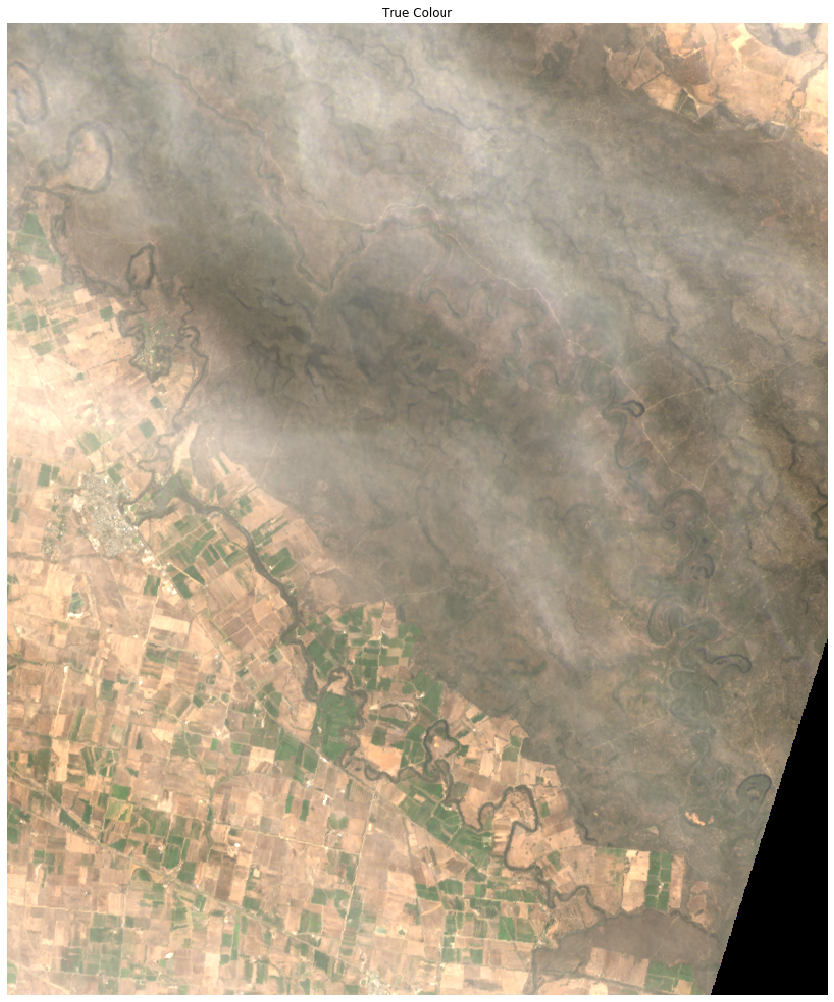

In [6]:
fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [7]:
TCI = TasseledCapTools.thresholded_tasseled_cap(data_lst8,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)

In [8]:
TCI

<xarray.Dataset>
Dimensions:                 (time: 91, x: 805, y: 954)
Coordinates:
  * time                    (time) datetime64[ns] 2017-01-04T00:15:37 ... 2018-12-25T00:15:17
  * y                       (y) float64 -3.953e+06 -3.953e+06 ... -3.976e+06
  * x                       (x) float64 1.099e+06 1.099e+06 ... 1.119e+06
Data variables:
    greenness               (time, y, x) float64 557.9 568.0 ... 286.1 286.1
    greenness_thresholded   (time, y, x) float64 nan nan nan nan ... nan nan nan
    brightness              (time, y, x) float64 3.319e+03 ... -2.287e+03
    brightness_thresholded  (time, y, x) float64 nan nan nan nan ... nan nan nan
    wetness                 (time, y, x) float64 -515.2 -487.9 ... 587.7 587.7
    wetness_thresholded     (time, y, x) float64 -515.2 -487.9 ... 587.7 587.7
Attributes:
    crs:      EPSG: 3577

In [9]:
tcw = TCI['wetness']


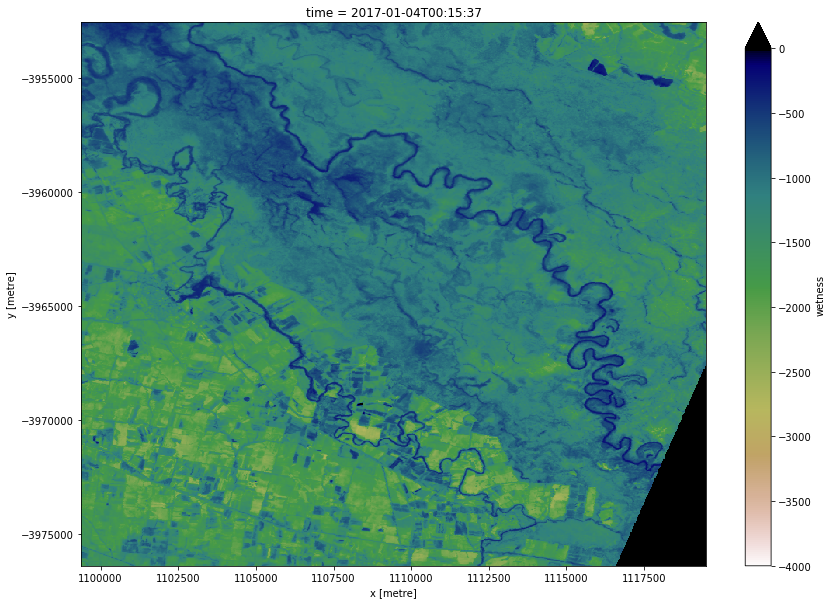

In [10]:
tcw.isel(time=0).plot(cmap='gist_earth_r',figsize=(14,10), vmin=-4000, vmax=0)#note -4000 is very low